<a href="https://colab.research.google.com/github/yweslakarep123/Capstone-Project_IBM-SkillsBuild_Klasifikasi-Mental-Health-Analisis-Depresi-Suicidal-Twitter/blob/main/Capstone_Project_IBM_SkillsBuild_Klasifikasi_Kategori_Mental_Health_dan_Analisis_Penyebab_Depressi_dan_Pikiran_Bunuh_Diri_Berdasarkan_Data_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Sambungkan Colab ke Drive</h2>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 <h2> Download Dataset dari Kaggle</h2>

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download suchintikasarkar/sentiment-analysis-for-mental-health

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


<h2>Ekstrak dataset</h2>

In [5]:
!pip install patool pyunpack


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/build_env.py", line 15, in <module>
    from pip._vendor.packaging.requirements import Requirement
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/packaging/requirements.py", line 8, in <module>
    from ._parser import parse_requirement as _parse_requirement
  File "/usr/local/lib/python3.12/dist-package

KeyboardInterrupt: 

In [ ]:
from pyunpack import Archive
zip_file_path = '/content/sentiment-analysis-for-mental-health.zip'
extract_directory = '/content/drive/MyDrive/Test_dataset'
# Buka dan ekstrak file ZIP menggunakan patool
Archive(zip_file_path).extractall(extract_directory)

# Output pesan jika ekstraksi selesai
print("Ekstraksi selesai.")

<h1>KLASIFIKASI</h1>

<h2>Import Library</h2>

In [6]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer
from transformers import BertModel
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

In [7]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

<h2>Import Dataset dari Drive ke Colab</h2>

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Test_dataset/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


<h2>Hapus Missing Value</h2>

In [9]:
df = df.dropna(axis=0)

In [10]:
df.drop(columns = ['Unnamed: 0'],inplace=True)

<h2>Plot Kategori dari Postingan Tweet Orang</h2>

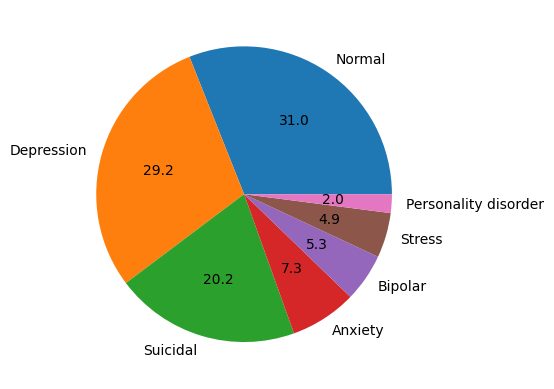

In [11]:
plt.pie(df['status'].value_counts(),labels=df['status'].value_counts().index,autopct='%.1f')
plt.show()

<h2>Encode Kategori Tersebut Menjadi Data Numerik</h2>

In [12]:
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

<h2> Karena Kategorinya Jumlahnya Tidak Merata, Maka Kita Apply Weighting Untuk Menyeimbangkan Data</h2>

In [13]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['status']),
    y=df['status']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

<h2>Proses Text yang Ada Didalam Data</h2>

In [14]:
def preprocess(text):
  text = re.sub(r"http\S+|www\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#", "", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [15]:
df['clean_text']=df['statement'].apply(preprocess)

<h2>Spilt Data</h2>

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df['clean_text'],df['status'],test_size=0.15,stratify=df["status"],random_state=42)

<h2>Siapkan Data Agar Bisa di Proses Pada Model dan Tokenizer IBM GRANITE</h2>

In [17]:
class MentalHealth_dataset(Dataset):
    def __init__(self, labels, tokens):
        self.labels = labels
        self.tokens = tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [18]:
tokenizer = AutoTokenizer.from_pretrained('ibm-granite/granite-embedding-30m-english')


In [19]:
training_tokens = tokenizer(list(X_train),truncation=True, padding='max_length', max_length=256, return_tensors='pt')
train_dataset = MentalHealth_dataset(y_train.tolist(),training_tokens)

test_tokens = tokenizer(list(X_test),truncation=True, padding='max_length', max_length=256, return_tensors='pt')
test_dataset = MentalHealth_dataset(y_test.tolist(),test_tokens)

In [20]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,prefetch_factor=2)
test_loader = DataLoader(test_dataset,batch_size=16,pin_memory=True,num_workers=2,persistent_workers=True)

<h2>Buat Model Klasifikasi IBM Granite yang Di Campur dengan LSTM</h2>

In [27]:
class BertLSTMClassifier(nn.Module):
    def __init__(self,
                 bert_model_name='ibm-granite/granite-embedding-30m-english',
                 num_classes=7,
                 dropout=0.3,
                 hidden_dims=128):
        super().__init__()

        # Load BERT
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Awalnya freeze semua parameter
        for param in self.bert.parameters():
            param.requires_grad = False

        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dims,
            bidirectional=True,
            batch_first=True
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Linear layer → in_features = hidden*6 (concat hidden, mean, max)
        self.linear = nn.Linear(hidden_dims*6, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedding = outputs.last_hidden_state  # [batch, seq_len, hidden]

        lstm_out, (h, c) = self.lstm(embedding)

        # BiLSTM last hidden state
        hidden = torch.cat((h[-2], h[-1]), dim=1)  # [batch, hidden*2]

        # Mean pooling + max pooling dari LSTM output
        mean_pool = torch.mean(lstm_out, dim=1)            # [batch, hidden*2]
        max_pool, _ = torch.max(lstm_out, dim=1)           # [batch, hidden*2]

        # Concatenate semua representasi
        pooled = torch.cat((hidden, mean_pool, max_pool), dim=1)  # [batch, hidden*6]

        out = self.dropout(pooled)
        logits = self.linear(out)
        return logits

    def unfreeze_last_layers(self, n_layers=2):
        for layer in self.bert.encoder.layer[-n_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


<h2>Pastikan Parameter yang Mau Kita Pakai</h2>

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)
criterior = nn.CrossEntropyLoss(weight=class_weights)
epochs = 10
learning_rate = 2e-4
model = BertLSTMClassifier()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


<h2> Train Model</h2>

In [29]:
for epoch in range(epochs):
  total_loss = 0
  for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    optimizer.zero_grad()

    logits = model(input_ids,attention_mask)

    loss = criterior(logits,labels)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f'Epoch : {epoch}, loss : {avg_loss}')

Epoch : 0, loss : 1.0639896691697288
Epoch : 1, loss : 0.8416044296122484
Epoch : 2, loss : 0.7689411081174051
Epoch : 3, loss : 0.7108634106679106
Epoch : 4, loss : 0.6535221615745664
Epoch : 5, loss : 0.592841056169208
Epoch : 6, loss : 0.5453781616920955
Epoch : 7, loss : 0.4960927277638385
Epoch : 8, loss : 0.45103164954978087
Epoch : 9, loss : 0.412365599637555


<h2> Evaluasi Performa Model</h2>

In [30]:
model.eval()
correct = 0
val_loss = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids,attention_mask)
        loss = criterior(logits,labels)
        val_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_val_loss = val_loss / len(test_loader)
accuracy = correct / total
print(f'avg_val_loss : {avg_val_loss}, accuracy : {accuracy}')

avg_val_loss : 0.8290878116089081, accuracy : 0.7416171074275592


<h2> Tampilkan Laporan Klasifiasinya</h2>

In [31]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=[
    "Normal", "Depression", "Suicidal", "Anxiety", "Bipolar", "Stress", "Personality Disorder"
]))

                      precision    recall  f1-score   support

              Normal       0.64      0.84      0.72       576
          Depression       0.80      0.73      0.76       417
            Suicidal       0.73      0.65      0.69      2311
             Anxiety       0.90      0.90      0.90      2452
             Bipolar       0.53      0.70      0.60       161
              Stress       0.52      0.66      0.58       388
Personality Disorder       0.64      0.62      0.63      1598

            accuracy                           0.74      7903
           macro avg       0.68      0.73      0.70      7903
        weighted avg       0.75      0.74      0.74      7903



<h1>ANALISIS</h1>

<h2> Install Library yang Di perlukan</h2>

In [32]:
!pip install wordcloud scikit-learn matplotlib seaborn replicate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.3 MB/s eta 0:00:00


<h2>Import Library</h2>

In [33]:
# IBM Granite - Replicate
import replicate
import os


In [34]:
df.head()

,statement,status,clean_text
0,oh my gosh,0,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",0,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",0,"All wrong, back off dear, forward doubt. Stay ..."
3,I've shifted my focus to something else but I'...,0,I've shifted my focus to something else but I'...
4,"I'm restless and restless, it's been a month n...",0,"I'm restless and restless, it's been a month n..."


In [35]:
df['status'].value_counts()

,count
status,
3,16343
2,15404
6,10652
0,3841
1,2777
5,2587
4,1077


<h2>Gunakan IBM GRANITE untuk menelusuri mengapa orang mempunyai depresi dan mempunyai pikiran untuk bunuh diri</h2>

In [39]:
import os
import replicate
from google.colab import userdata

# Ambil token dari Colab
Token = userdata.get("REPLICATE_API_TOKEN")
os.environ["REPLICATE_API_TOKEN"] = Token

# Load model Granite
model = replicate.models.get("ibm-granite/granite-3.3-8b-instruct")

def summarize_with_granite(text_list, sentiment_label):
    """Ringkas opini publik menggunakan IBM Granite via Replicate"""
    examples = "\n".join(f"- {t}" for t in text_list)  # kasih bullet biar rapi
    prompt = (
        f"You are analyzing public tweets labeled as {sentiment_label}.\n"
        f"Here are {len(text_list)} sample tweets:\n{examples}\n\n"
        f"Please summarize the main reasons why people feel {sentiment_label.lower()}, "
        f"and explain the psychological or social factors behind these expressions."
    )

    try:
        output = replicate.run(
            model,
            input={
                "prompt": prompt,
                "max_new_tokens": 200
            }
        )
        return "".join(output)
    except Exception as e:
        return f"Summarization gagal: {e}"

# Ambil 10 contoh tweet untuk masing-masing kategori
Depression_examples = df[df['status'] == 2]['clean_text'] \
    .sample(min(10, len(df[df['status'] == 2])), random_state=42).tolist()

Suicidal_examples = df[df['status'] == 6]['clean_text'] \
    .sample(min(10, len(df[df['status'] == 6])), random_state=42).tolist()

# Cetak hasil ringkasan
print("\n=== Summarization Sentimen Depression ===")
print(summarize_with_granite(Depression_examples, "Depression"))

print("\n=== Summarization Sentimen Suicidal ===")
print(summarize_with_granite(Suicidal_examples, "Suicidal"))



=== Summarization Sentimen Depression ===
The provided tweets reveal several common reasons and psychological/social factors contributing to feelings of depression:

1. **Relationship issues**: Many tweets express depression stemming from relationship problems, such as unhappy marriages, lack of understanding from friends and family, and feelings of isolation. These relationship difficulties can lead to intense emotional distress, loneliness, and a sense of worthlessness.

2. **Mental health struggles**: Several tweets mention ongoing battles with depression, anxiety, and suicidal ideation. The constant internal struggle with these conditions can erode self-esteem, create feelings of hopelessness, and make daily life challenging.

3. **Lack of support**: The absence of understanding, empathy, or practical help from loved ones exacerbates feelings of depression. The tweeter expressing suicidal thoughts fears burdening their friend, highlighting the weight of not having a solid support 